![FOOD](http://www.rykneldhomes.org.uk/EasysiteWeb/getresource.axd?AssetID=88915&type=full&servicetype=Inline)**Prediction of cuisine ** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print("Listing in the working directory:", os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Listing in the working directory: ['train.json', 'test.json', 'sample_submission.csv']


The files given are in json format

In [2]:
# Load files and examine first few rows

train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

train.head(10) 


,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [3]:
# What are the data types in the training dataset?
train.dtypes

cuisine        object
id              int64
ingredients    object
dtype: object

In [4]:
# What is the size of this data? 

train.shape

(39774, 3)

In [5]:
# What are the different cuisines occuring in this data?
distinct_cuisines=train.cuisine.unique()
print(distinct_cuisines)

['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [6]:
# What is the count of these unique cuisines?
len(distinct_cuisines)

20

In [7]:
# How many times have these cuisines occured in the data? 

train.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [8]:
# What is the cuisine with highest number of ingredients and the lowest?
max_item=train['ingredients'].str.len().max()
min_item=train['ingredients'].str.len().min()

print(max_item)
print(min_item)

65
1


In [9]:
train.isnull().any()

cuisine        False
id             False
ingredients    False
dtype: bool

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4beefe30f0>]],
      dtype=object)

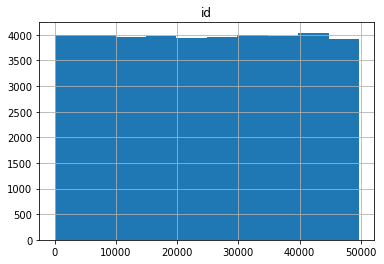

In [10]:
import matplotlib.pyplot as plt
train.hist()

In [11]:
train['num_ingredients'] = train['ingredients'].apply(len)
train = train[train['num_ingredients'] > 1]

In [12]:
features = [] # list of list containg the recipes
for item in train['ingredients']:
    features.append(item)

In [13]:
ingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train['ingredients']:
    for ingr in item:
        ingredients.append(ingr) 

In [15]:
# Fit the TfidfVectorizer to data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(vocabulary= list(set([str(i).lower() for i in ingredients])), max_df=0.99, norm='l2', ngram_range=(1, 4))
X_tr = tfidf.fit_transform([str(i) for i in features]) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(vocabulary= list(set([str(i).lower() for i in ingredients])), max_df=0.99, norm='l2', ngram_range=(1, 4))
X_tr = tfidf.fit_transform([str(i) for i in features]) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()

In [17]:
# Extract the target variable
target = train['cuisine']

In [18]:
# Train sample 
print("How training data looks like at this stage (example of one recipe):")
print(str(features[0]) + '\n' )
print("Number of records: "+ str(len(features)) + '\n')
print("target variable for this record:")
print(target[0])

How training data looks like at this stage (example of one recipe):
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']

Number of records: 39752

target variable for this record:
greek


In [20]:
# Train
import re

features_processed= [] # here we will store the preprocessed training features
for item in features:
    newitem = []
    for ingr in item:
        ingr.lower() # Case Normalization - convert all to lower case 
        ingr = re.sub("[^a-zA-Z]"," ",ingr) # Remove punctuation, digits or special characters 
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) # Remove different units  
        newitem.append(ingr)
    features_processed.append(newitem)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# Binary representation of the training set will be employed
vectorizer = CountVectorizer(analyzer = "word",
                             ngram_range = (1,1), # unigrams
                             binary = True, #  (the default is counts)
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,  
                             max_df = 0.99)

In [22]:
train_X = vectorizer.fit_transform([str(i) for i in features_processed])

lb = LabelEncoder()
train_Y = lb.fit_transform(target)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, Y_train, Y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(train_X, train_Y)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
Y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression model'.format(logreg.score(X_test, Y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

Accuracy of logistic regression model
[[  80    0    0    0    2    2    0    5    1   13    0    0    0   17
     0    0    6    2    1    0]
 [   0  135    0    0    1   31    1    5   11   17    1    2    0    3
     1    3   41    0    1    0]
 [   0    4  370    1    0   17    0    2    1   20    0    0    0   11
     0    0   54    5    0    0]
 [   1    2    0  711    2    0    0    5    0    8    1   15    9    3
     0    1    3    0    7   10]
 [   3    1    1   16  153    3    0    1    0    4    0    2    0    6
     0    1   12    1    5    2]
 [   1    7    4    1    0  593    2    1    4  110    0    4    0    7
     2    7   40    7    0    1]
 [   0    1    0    0    0    8  291    3    0   29    0    1    1    6
     3    1    3    4    0    0]
 [   0    1    1    1    2    4    4  845    1    6    1    1    0   11
     8    0    4    0    6    0]
 [   0   13    0    0    0   14    1    1  136    8    0    0    0    1
     1    0   28    2    0    0]
 [   1    6    3 

In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       129
           1       0.72      0.53      0.61       253
           2       0.88      0.76      0.82       485
           3       0.85      0.91      0.88       778
           4       0.83      0.73      0.77       211
           5       0.72      0.75      0.73       791
           6       0.86      0.83      0.84       351
           7       0.88      0.94      0.91       896
           8       0.82      0.66      0.74       205
           9       0.85      0.93      0.89      2342
          10       0.92      0.77      0.84       159
          11       0.87      0.77      0.82       445
          12       0.92      0.85      0.88       246
          13       0.92      0.95      0.93      1913
          14       0.90      0.82      0.86       261
          15       0.83      0.60      0.70       165
          16       0.77      0.85      0.81      1269
          17       0.79    